In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/RegionalSpanish/notebooks/j1.8`


In [2]:
#=Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.9"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="TextSearch", version="0.13"),
    PackageSpec(name="JLD2", version="0.16"),
    PackageSpec(name="HDF5", version="0.4"),
    PackageSpec(name="CSV", version="0.10"),
    PackageSpec(name="DataFrames", version="1"),
    PackageSpec(name="Glob", version="1"),
    PackageSpec(name="StatsBase", version="0.33"),
    PackageSpec(name="Plots", version="1"),
    PackageSpec(name="JSON", version="0.21"),
])
=#
Pkg.status()

Status `~/Research/RegionalSpanish/notebooks/j1.8/Project.toml`
  [336ed68f] CSV v0.10.7
  [a93c6f00] DataFrames v1.4.3
  [c27321d9] Glob v1.3.0
  [f67ccb44] HDF5 v0.16.12
  [b20bd276] InvertedFiles v0.4.3
  [033835bb] JLD2 v0.4.28
  [682c06a0] JSON v0.21.3
⌃ [91a5bcdd] Plots v1.36.1
  [ca7ab67e] SimSearchManifoldLearning v0.2.6 `~/Research/SimSearchManifoldLearning.jl`
  [053f045d] SimilaritySearch v0.9.8
  [2913bbd2] StatsBase v0.33.21
  [7f6f6c8a] TextSearch v0.13.2
  [0ae4a718] VegaDatasets v2.1.1
  [112f6efa] VegaLite v2.6.0
Info Packages marked with ⌃ have new versions available


In [3]:
#Pkg.develop(path="/home/sadit/Research/SimSearchManifoldLearning.jl")

In [4]:
using SimilaritySearch, SimSearchManifoldLearning, TextSearch, LinearAlgebra, HDF5, JSON, JLD2, CSV, DataFrames, Glob, StatsBase, Plots

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1662
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1662


In [5]:
pwd()

"/home/sadit/Research/RegionalSpanish/notebooks/j1.8"

In [6]:
edir = "../../data/SpanishLang/embeddings"
k = 33
common = CSV.read("../../data/SpanishLang/common-tokens-per-region.tsv.gz", DataFrame, delim='\t')
subset!(common, :n_regions => n -> n .> 10)
cclist = split(first(subset(common, :n_regions => n -> n .== 26).country_codes), ',')
cclist = [cc for cc in cclist if cc != "GQ"]  # removing GQ since it has too few intersecting tokens
@info sort!(cclist)

┌ Info: SubString{String}["ALL", "AR", "BO", "BR", "CA", "CL", "CO", "CR", "CU", "DO", "EC", "ES", "FR", "GB", "GT", "HN", "MX", "NI", "PA", "PE", "PR", "PY", "SV", "US", "UY", "VE"]
└ @ Main In[6]:7


In [7]:
function encode_model(knns, dists, vocab)
    #vocab = Symbol.(vocab)
    #  ivocab = Dict(token => i for (i, token) in enumerate(vocab))
    obj = Dict{UInt64,Float64}()
    for (i, (idcol, distcol)) in enumerate(zip(eachcol(knns), eachcol(dists)))
        for j in eachindex(idcol, distcol)
            w = (vocab[i], vocab[idcol[j]])
            s = hash(w)
            obj[s] = 1.0 + 1 / (1 + distcol[j])
        end
    end
 
    normalize!(obj)
end

encode_model (generic function with 1 method)

In [8]:
db = []

for cc in cclist
    modelname = only(glob(joinpath(edir, "knns-common-tokens.cc=$cc*.h5")))
    @info modelname
    knns_, dists_, vocab_ = load(modelname, "knns", "dists", "vocab")
    push!(db, encode_model(knns_, dists_, vocab_))
end

length(db)

┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=ALL-1.7m.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=AR.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=BO.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=BR.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=CA.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=CL.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=CO.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=CR.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=CU.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=DO.k=33.h5
└ @ Main In[8]:5
┌ Info: ../../data/SpanishLang/embeddings/knns-common-tokens.cc=EC.k=33.h5

26

In [9]:
dist = NormalizedCosineDistance()
n = length(cclist)
A = Matrix{Float64}(undef, n, n)

for (i, cc) in enumerate(cclist)
    u = db[i]
    A[i, i] = 0.0
    @time for j in i+1:n
        v = db[j]
        A[j, i] = A[i, j] = evaluate(dist, u, v)
    end
end

  2.592015 seconds (29.92 k allocations: 1.529 MiB, 1.26% compilation time)
  2.376927 seconds (49 allocations: 1.156 KiB)
  1.342909 seconds (47 allocations: 1.109 KiB)
  1.600180 seconds (45 allocations: 1.062 KiB)
  1.354652 seconds (43 allocations: 1.016 KiB)
  1.999404 seconds (42 allocations: 1024 bytes)
  1.851218 seconds (39 allocations: 944 bytes)
  1.516611 seconds (37 allocations: 896 bytes)
  0.420192 seconds (35 allocations: 848 bytes)
  1.415582 seconds (33 allocations: 800 bytes)
  1.453412 seconds (31 allocations: 752 bytes)
  1.378275 seconds (29 allocations: 704 bytes)
  0.873072 seconds (27 allocations: 656 bytes)
  0.859314 seconds (25 allocations: 608 bytes)
  0.845933 seconds (23 allocations: 560 bytes)
  0.631785 seconds (21 allocations: 512 bytes)
  0.927199 seconds (19 allocations: 464 bytes)
  0.531577 seconds (17 allocations: 416 bytes)
  0.662624 seconds (15 allocations: 368 bytes)
  0.605816 seconds (13 allocations: 320 bytes)
  0.156740 seconds (11 allocat

In [37]:
min_dist = 0.2
k = 10
neg_sample_rate = 5
local_connectivity = 1
n_epochs = 300
tol = 1e-5

1.0e-5

In [38]:
U2 = fit(UMAP, PrecomputedAffinityMatrix(A); maxoutdim=2, layout=SpectralLayout(),
        k, local_connectivity, neg_sample_rate, min_dist, n_epochs, tol)
U3 = fit(U2, 3)

  0.000209 seconds (5 allocations: 2.719 KiB)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.5835e-5
- embedding init: 0.000395652
- embedding opt: 0.050800567



UMAP(sparse(Int32[2, 6, 7, 12, 17, 20, 24, 25, 26, 1  …  7, 10, 11, 12, 17, 19, 20, 22, 24, 25], [1, 1, 1, 1, 1, 1, 1, 1, 1, 2  …  26, 26, 26, 26, 26, 26, 26, 26, 26, 26], Float32[1.0, 0.23422495, 0.40251982, 1.0, 1.0, 0.08036061, 0.23059306, 0.073942505, 0.21444498, 1.0  …  1.0, 0.132056, 0.51548344, 0.31792724, 0.2804309, 0.052895986, 0.6511482, 0.034596212, 1.0, 0.24668927], 26, 26), Float32[5.1880555 4.633945 … 4.405363 4.5548735; 1.1139789 1.8998613 … 1.189578 0.24636501; 1.5559908 0.7264075 … -0.3179714 1.3447616], 10, 1.2620581f0, 1.0030054f0, PrecomputedAffinityMatrix{Matrix{Float64}}([0.0 0.5141432491661109 … 0.6808083448433957 0.62942088710882; 0.5141432491661109 0.0 … 0.6202485716523354 0.6363045953112867; … ; 0.6808083448433957 0.6202485716523354 … 0.0 0.6251938922092478; 0.62942088710882 0.6363045953112867 … 0.6251938922092478 0.0]))

In [39]:
X = predict(U2)
C = predict(U3)
#C .= C .+ 5

for i in (1, 2, 3)
    v = @view C[i, :]
    s = 4 * std(v)
    v .= v ./ s .+ 0.5
    
    for j in eachindex(v)
        v[j] = clamp(v[j],  0, 1)
    end
end

C = [RGB(c...) for c in eachcol(C)]

┌ Info: (:r, :g, :b)
└ @ Main In[40]:13


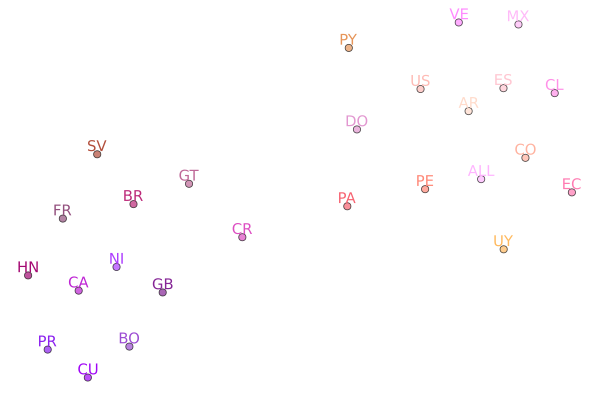

In [40]:

#poslist = rand([:right, :left, :bottom, :top], length(cclist))
poslist = rand([:bottom], length(cclist))

scatter(X[1, :], X[2, :], c=C, label="",
    series_annotations=[text(cclist[i], poslist[i], 10, C[i]) for i in eachindex(cclist)], xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
    ms=4, ma=0.7, fa=0.7, la=0.7, alpha=0.7)
#scatter!(X[1, :], X[2, :], c=C, label="",
#    series_annotations=[text(cclist[i], poslist[i], 10, C[i]) for i in eachindex(cclist)], xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
#    ms=5, ma=0.5, fa=0.5, la=0.5, alpha=0.5)
savefig("../../figs/fig-voc-semantic-umap.pdf")
savefig("../../figs/fig-voc-semantic-umap.png")
@info fieldnames(typeof(C[1]))
open("../../figs/colormap-common-voc-semantic-$k.csv", "w") do f
    println(f, "country,R,G,B")
    for (i, (cc, c)) in enumerate(zip(cclist, C))
        println(f, cc, ",", c.r, ",", c.g, ",", c.b)
    end
end
plot!(fmt=:png)

In [41]:
#=D = Dict(zip(cclist, db))
@show [
evaluate(dist, D["MX"], D["MX"])
evaluate(dist, D["MX"], D["ALL"])
evaluate(dist, D["MX"], D["SV"])
evaluate(dist, D["ES"], D["GQ"])
]

@info D["MX"][:iglesia]
@info D["US"][:iglesia]
=#

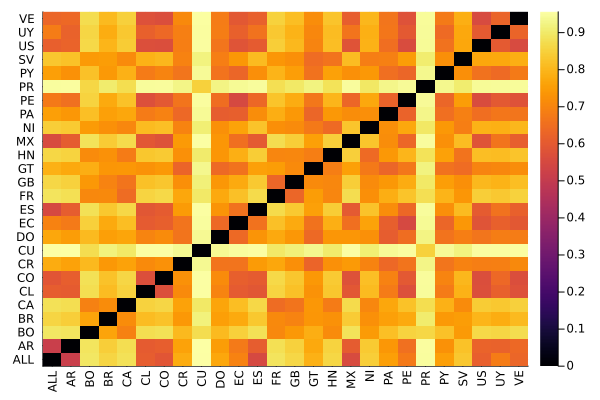

In [42]:
heatmap(cclist, cclist, A, ticks = :all, xrot=90)
savefig("../../figs/fig-common-words-semantic-affinity-matrix.pdf")
savefig("../../figs/fig-common-words-semantic-affinity-matrix.png")
plot!(fmt=:png)